<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/06-dl-pytorch-food/food_image_classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries for data handling, visualization, and deep learning.
import os
import requests
import zipfile
import io
import numpy as np
import random
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [ ]:
# Set random seed for reproducibility of results
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Choose device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using this device: {device}')

Using this device: cuda


## Utility function(s)

In [ ]:
def count_images_per_class(folder_path):
    """
    Count the number of images in each class subfolder of the given directory.

    Parameters
    ----------
    folder_path : str
        Path to the parent directory containing one subdirectory per class.

    Returns
    -------
    dict
        A dictionary mapping class names to the number of images in each subfolder.
    """
    counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            counts[class_name] = len(os.listdir(class_folder))
    return counts

In [ ]:
def evaluate(model, dataloader):
  """
  Evaluates a PyTorch model on a given validation dataset.

  Parameters
  ----------
  model : torch.nn.Module
      The model to evaluate.
  dataloader : torch.utils.data.DataLoader
      DataLoader yielding batches from the validation set.

  Returns
  -------
  val_loss : float
      Average validation loss over all batches.
  val_accuracy : float
      Classification accuracy on the validation set.
  """
  model.eval()
  val_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)

      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return val_loss/len(dataloader), correct/total

In [ ]:
def evaluate_on_test(model, test_loader):
  """
  Runs model inference on the test set and collects all true and predicted labels.

  Parameters
  ----------
  model : torch.nn.Module
      Trained model for evaluation.
  test_loader : torch.utils.data.DataLoader
      DataLoader for the test dataset.

  Returns
  -------
  y_true : list of int
      Ground truth class indices.
  y_pred : list of int
      Predicted class indices by the model.
  """
  y_true, y_pred = [], []
  model.eval()
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
  return y_true, y_pred

In [ ]:
def set_optimizer(model, lr, weight_decay=1e-4, t_max=10):
    """
    Creates an AdamW optimizer and CosineAnnealingLR scheduler for model training.

    Parameters
    ----------
    model : torch.nn.Module
        The model with parameters to be optimized.
    lr : float
        Initial learning rate.
    weight_decay : float, optional
        L2 regularization coefficient. Default is 1e-4.
    t_max : int, optional
        Number of iterations for cosine annealing scheduler. Default is 10.

    Returns
    -------
    optimizer : torch.optim.Optimizer
        Configured AdamW optimizer.
    scheduler : torch.optim.lr_scheduler._LRScheduler
        CosineAnnealingLR scheduler.
    """
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)
    return optimizer, scheduler

In [ ]:
def save_training_logs(train_losses, val_losses, train_accs, val_accs, filename):
    """
    Saves training and validation loss and accuracy logs to a JSON file.

    Parameters
    ----------
    train_losses : list of float
        List of training loss values for each epoch.
    val_losses : list of float
        List of validation loss values for each epoch.
    train_accs : list of float
        List of training accuracy values for each epoch.
    val_accs : list of float
        List of validation accuracy values for each epoch.
    filename : str
        Path to the JSON file where logs will be saved.

    Returns
    -------
    None
    """
    logs = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }
    with open(filename, "w") as f:
        json.dump(logs, f)
    print(f"Logs saved to {filename}")

In [ ]:
def load_training_logs(filename):
    """
    Loads training and validation loss and accuracy logs from a JSON file.

    Parameters
    ----------
    filename : str
        Path to the JSON file containing the logs.

    Returns
    -------
    train_losses : list of float
        List of training loss values per epoch.
    val_losses : list of float
        List of validation loss values per epoch.
    train_accs : list of float
        List of training accuracy values per epoch.
    val_accs : list of float
        List of validation accuracy values per epoch.
    """
    with open(filename, "r") as f:
        logs = json.load(f)
    print(f"Logs loaded from {filename}")
    return (logs["train_losses"], logs["val_losses"],
            logs["train_accs"], logs["val_accs"])


In [ ]:
def print_results(y_true, y_pred):
  """
  Prints classification results including accuracy, macro F1-score, and a classification report.

  Parameters
  ----------
  y_true : list or numpy.ndarray
      Ground truth class labels.
  y_pred : list or numpy.ndarray
      Predicted class labels.

  Returns
  -------
  None
  """
  # Accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Test Accuracy: {accuracy*100:.2f}%')

  # F1-score macro
  f1 = f1_score(y_true, y_pred, average="macro")
  print(f"Macro F1-score: {f1:.4f}")

  # Classification report
  print("Classification Report:")
  print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def plot_curves(train_losses, val_losses, train_accs, val_accs, title="Training Curves"):
    """
    Plots training and validation loss and accuracy curves over epochs.

    Parameters
    ----------
    train_losses : list of float
        Training loss at each epoch.
    val_losses : list of float
        Validation loss at each epoch.
    train_accs : list of float
        Training accuracy at each epoch.
    val_accs : list of float
        Validation accuracy at each epoch.
    title : str, optional
        Overall plot title.

    Returns
    -------
    None
    """
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.suptitle(title)
    plt.show()

In [ ]:
def show_confusion_matrix(y_true, y_pred):
  """
  Plots the confusion matrix for given true and predicted class labels using a heatmap.

  Parameters
  ----------
  y_true : list or numpy.ndarray
      Ground truth class labels.
  y_pred : list or numpy.ndarray
      Predicted class labels by the model.

  Returns
  -------
  None
  """
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
              xticklabels=class_names, yticklabels=class_names)

  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")

  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.show()

## Dataset Preparation and Augmentation

In [ ]:
# Download and unzip the dataset from the given URL
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip"

response = requests.get(url)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

zip_file.extractall("/content/")


In [ ]:
# Wrapper for using Albumentations with PyTorch Datasets
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL -> NumPy array
        img = np.array(img)
        return self.transform(image=img)["image"]

In [ ]:
# Define data augmentation pipeline for training images
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Augmentation pipeline for validation/test (no random operations)
val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# Prepare datasets with class folders; apply appropriate transforms
train_dataset = ImageFolder(root='/content/dataset/train', transform=AlbumentationsTransform(train_transform))
val_dataset = ImageFolder(root='/content/dataset/val', transform=AlbumentationsTransform(val_test_transform))
test_dataset = ImageFolder(root='/content/dataset/test', transform=AlbumentationsTransform(val_test_transform))

# Create DataLoaders to efficiently batch and shuffle data for training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Get the class names list
class_names = train_loader.dataset.classes

In [ ]:
# Print dataset statistics
print(f'Train samples: {len(train_dataset)}')
print(f'Valid samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

train_counts = count_images_per_class('/content/dataset/train')
val_counts = count_images_per_class('/content/dataset/val')
test_counts = count_images_per_class('/content/dataset/test')

print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)
print("Test class distribution:", test_counts)

Train samples: 8960
Valid samples: 2240
Test samples: 2800
Train class distribution: {'apple_pie': 640, 'Baked Potato': 640, 'Taquito': 640, 'Crispy Chicken': 640, 'chicken_curry': 640, 'Fries': 640, 'Taco': 640, 'omelette': 640, 'Donut': 640, 'ice_cream': 640, 'sushi': 640, 'Hot Dog': 640, 'cheesecake': 640, 'Sandwich': 640}
Validation class distribution: {'apple_pie': 160, 'Baked Potato': 160, 'Taquito': 160, 'Crispy Chicken': 160, 'chicken_curry': 160, 'Fries': 160, 'Taco': 160, 'omelette': 160, 'Donut': 160, 'ice_cream': 160, 'sushi': 160, 'Hot Dog': 160, 'cheesecake': 160, 'Sandwich': 160}
Test class distribution: {'apple_pie': 200, 'Baked Potato': 200, 'Taquito': 200, 'Crispy Chicken': 200, 'chicken_curry': 200, 'Fries': 200, 'Taco': 200, 'omelette': 200, 'Donut': 200, 'ice_cream': 200, 'sushi': 200, 'Hot Dog': 200, 'cheesecake': 200, 'Sandwich': 200}


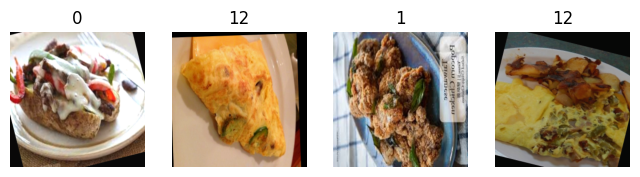

In [ ]:
# Prepare tensors for image denormalization (revert normalized images to viewable format)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denormalize(img):
    return img * std + mean

# Visualize examplse images from training set
examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8,3))

for i in range(4):
    plt.subplot(1,4,i+1)
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).clamp(0,1)
    plt.imshow(img)
    plt.title(str(labels[i].item()))
    plt.axis('off')

plt.show()

## Baseline Model Training
Train a ResNet50 model with frozen layers as a feature extractor.

### Training Details
- Loss function: CrossEntropyLoss  
- Optimizer: AdamW, LR=1e-3  
- Early stopping patience: 5  
- Epochs: max 40  

In [ ]:
# Early stopping utility to avoid overfitting (stop if no val improvement for X epochs)
class EarlyStopping:
  def __init__(self, patience=5):
      self.patience = patience
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss is None or val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter == self.patience:
        self.early_stop = True

In [ ]:
# Create ResNet50 baseline model for 14 food classes
num_classes = 14
baseline_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# Freeze all parameters to use as feature extractor
for param in baseline_model.parameters():
  param.requires_grad = False
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, num_classes)
baseline_model = baseline_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [ ]:
# Define loss function and optimizer/scheduler for baseline model training
criterion = nn.CrossEntropyLoss()
# AdamW
optimizer = optim.AdamW(baseline_model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
# CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# Set number of epochs
epochs = 40

In [ ]:
early_stopping = EarlyStopping(patience=5)

# Initialize logs for loss/accuracy
baseline_train_losses, baseline_val_losses = [], []
baseline_train_accs, baseline_val_accs = [], []

best_val_loss = float('inf')

# Training loop for baseline model
for epoch in range(epochs):
    baseline_model.train()
    correct_train, total_train = 0, 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Track training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    scheduler.step()
    val_loss, val_acc = evaluate(baseline_model, val_loader)

    # Logging
    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_train_accs.append(train_acc)
    baseline_val_accs.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(baseline_model.state_dict(), 'best_baseline_model.pth')
        print("Best baseline model saved")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

[Epoch 1] Train Loss: 1.8312, Train Acc: 0.4699, Val Loss: 1.0538, Val Acc: 0.7312
Best baseline model saved
[Epoch 2] Train Loss: 1.1981, Train Acc: 0.6552, Val Loss: 0.8470, Val Acc: 0.7531
Best baseline model saved
[Epoch 3] Train Loss: 1.0430, Train Acc: 0.6926, Val Loss: 0.7251, Val Acc: 0.7844
Best baseline model saved
[Epoch 4] Train Loss: 0.9670, Train Acc: 0.7077, Val Loss: 0.7260, Val Acc: 0.7696
[Epoch 5] Train Loss: 0.9143, Train Acc: 0.7190, Val Loss: 0.6709, Val Acc: 0.7964
Best baseline model saved
[Epoch 6] Train Loss: 0.8832, Train Acc: 0.7270, Val Loss: 0.6524, Val Acc: 0.7978
Best baseline model saved
[Epoch 7] Train Loss: 0.8727, Train Acc: 0.7329, Val Loss: 0.6330, Val Acc: 0.8058
Best baseline model saved
[Epoch 8] Train Loss: 0.8579, Train Acc: 0.7333, Val Loss: 0.6265, Val Acc: 0.8054
Best baseline model saved
[Epoch 9] Train Loss: 0.8452, Train Acc: 0.7406, Val Loss: 0.6328, Val Acc: 0.8031
[Epoch 10] Train Loss: 0.8425, Train Acc: 0.7400, Val Loss: 0.6229, Val

In [ ]:
# Saving training logs
save_training_logs(baseline_train_losses, baseline_val_losses,
                   baseline_train_accs, baseline_val_accs,
                   "baseline_logs.json")

Logs saved to baseline_logs.json


## Evaluation and Results
Plot training curves, generate classification reports, and visualize confusion matrix.

* File can be found on GitHub repo

In [ ]:
# loading the baseline model
baseline_model.load_state_dict(torch.load('best_baseline_model.pth'))
baseline_model.to(device)

In [ ]:
# Evaluate baseline model on test set
y_true_base, y_pred_base = evaluate_on_test(baseline_model, test_loader)
print("Baseline Results")
print_results(y_true_base, y_pred_base)

Baseline Results
Test Accuracy: 81.93%
Macro F1-score: 0.8180
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.84      0.88      0.86       200
Crispy Chicken       0.85      0.88      0.86       200
         Donut       0.91      0.96      0.93       200
         Fries       0.90      0.91      0.90       200
       Hot Dog       0.77      0.82      0.79       200
      Sandwich       0.80      0.81      0.81       200
          Taco       0.70      0.56      0.62       200
       Taquito       0.76      0.73      0.75       200
     apple_pie       0.69      0.77      0.73       200
    cheesecake       0.83      0.85      0.84       200
 chicken_curry       0.83      0.86      0.85       200
     ice_cream       0.86      0.81      0.83       200
      omelette       0.82      0.80      0.81       200
         sushi       0.91      0.83      0.87       200

      accuracy                           0.82      2800
     macro avg   

Logs loaded from baseline_logs.json


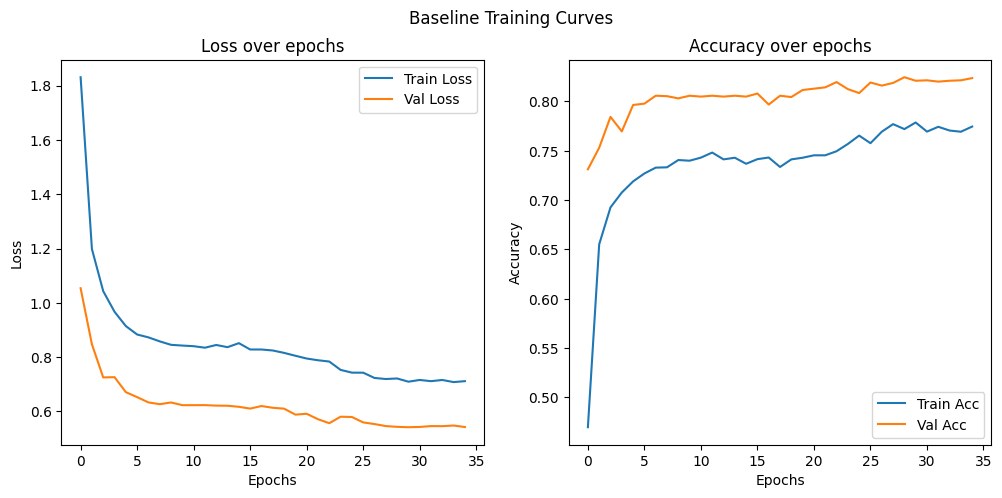

In [ ]:
# Plot training curves for baseline model
train_losses, val_losses, train_accs, val_accs = load_training_logs("baseline_logs.json")
plot_curves(train_losses, val_losses, train_accs, val_accs, title="Baseline Training Curves")

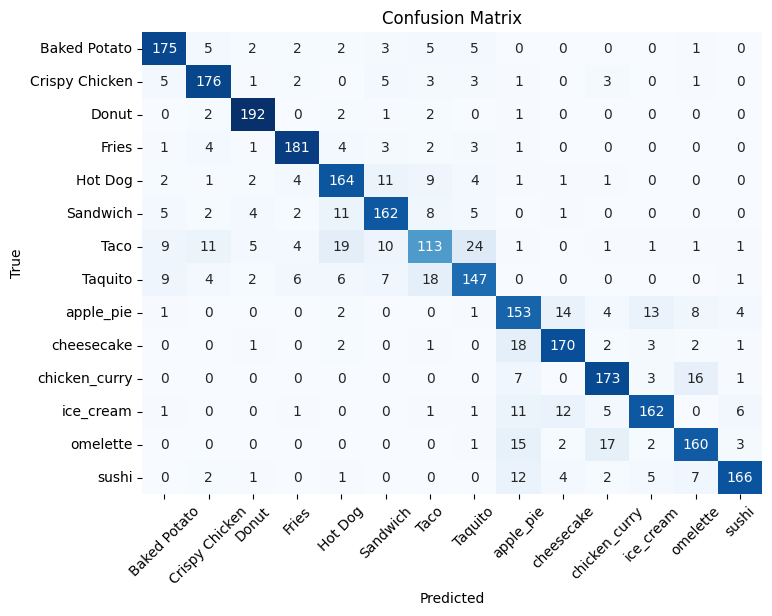

In [ ]:
# Show confusion matrix for baseline
show_confusion_matrix(y_true_base, y_pred_base)

## Fine-Tuning the Model
Unfreeze deeper layers gradually and train with decreasing learning rates.

In [ ]:
# Recreate the model with the same architecture
fine_tuned_model = models.resnet50(weights=None)  # no need to reload ImageNet weights here
num_ftrs = fine_tuned_model.fc.in_features
fine_tuned_model.fc = nn.Linear(num_ftrs, 14)  # adattato alle 14 classi

# Load the trained baseline weights
fine_tuned_model.load_state_dict(torch.load('best_baseline_model.pth'))

# Move to device
fine_tuned_model.to(device)

In [ ]:
early_stopping = EarlyStopping(patience=5)

# Logs for fine-tuning training
finetune_train_losses, finetune_val_losses = [], []
finetune_train_accs, finetune_val_accs = [], []

# Training loop for gradual unfreezing/fine tuning
for epoch in range(epochs):
    # Gradually unfreeze more layers and change learning rate as training progresses
    if epoch == 0:
        for name, param in fine_tuned_model.named_parameters():
            param.requires_grad = ("fc" in name)
        optimizer, scheduler = set_optimizer(fine_tuned_model, lr=1e-3)

    elif epoch == 5:
        for name, param in fine_tuned_model.named_parameters():
            param.requires_grad = ("fc" in name or "layer4" in name)
        optimizer, scheduler = set_optimizer(fine_tuned_model, lr=1e-4)

    elif epoch == 10:
        for name, param in fine_tuned_model.named_parameters():
            param.requires_grad = ("fc" in name or "layer4" in name or "layer3" in name)
        optimizer, scheduler = set_optimizer(fine_tuned_model, lr=1e-5)

    # Training phase for fine-tuned model
    fine_tuned_model.train()
    running_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = fine_tuned_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    scheduler.step()
    val_loss, val_acc = evaluate(fine_tuned_model, val_loader)

    # Logging
    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)
    finetune_train_accs.append(train_acc)
    finetune_val_accs.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model for lowest val loss
    if early_stopping.best_loss is None or val_loss < early_stopping.best_loss:
        torch.save(fine_tuned_model.state_dict(), "best_finetuned_model.pth")
        print("Best fine-tuned model saved")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

[Epoch 1] Train Loss: 0.7652, Train Acc: 0.7567, Val Loss: 0.5578, Val Acc: 0.8196
Best fine-tuned model saved
[Epoch 2] Train Loss: 0.7261, Train Acc: 0.7674, Val Loss: 0.5497, Val Acc: 0.8210
Best fine-tuned model saved
[Epoch 3] Train Loss: 0.7325, Train Acc: 0.7621, Val Loss: 0.5674, Val Acc: 0.8138
[Epoch 4] Train Loss: 0.7239, Train Acc: 0.7696, Val Loss: 0.5505, Val Acc: 0.8152
[Epoch 5] Train Loss: 0.7165, Train Acc: 0.7672, Val Loss: 0.5540, Val Acc: 0.8152
[Epoch 6] Train Loss: 0.6604, Train Acc: 0.7872, Val Loss: 0.4510, Val Acc: 0.8580
Best fine-tuned model saved
[Epoch 7] Train Loss: 0.4459, Train Acc: 0.8546, Val Loss: 0.4369, Val Acc: 0.8679
Best fine-tuned model saved
[Epoch 8] Train Loss: 0.3455, Train Acc: 0.8854, Val Loss: 0.4063, Val Acc: 0.8772
Best fine-tuned model saved
[Epoch 9] Train Loss: 0.2751, Train Acc: 0.9119, Val Loss: 0.3876, Val Acc: 0.8786
Best fine-tuned model saved
[Epoch 10] Train Loss: 0.2253, Train Acc: 0.9268, Val Loss: 0.3839, Val Acc: 0.8826
B

In [ ]:
# Saving training logs for fined-tuned model
save_training_logs(finetune_train_losses, finetune_val_losses,
                   finetune_train_accs, finetune_val_accs,
                   "finetune_logs.json")

Logs saved to finetune_logs.json


## Evaluation and Results
Plot training curves, generate classification reports, and visualize confusion matrix.


In [ ]:
# Load best fine-tuned parameters before final evaluation
fine_tuned_model.load_state_dict(torch.load("best_finetuned_model.pth"))
fine_tuned_model.to(device)

Logs loaded from finetune_logs.json


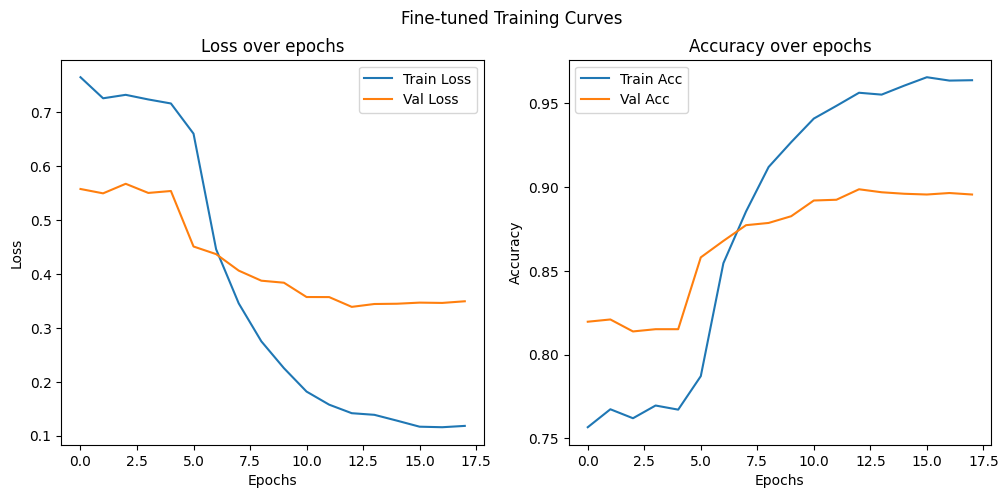

In [ ]:
# Plot curves for fine-tuned training
train_losses, val_losses, train_accs, val_accs = load_training_logs("finetune_logs.json")
plot_curves(train_losses, val_losses, train_accs, val_accs, title="Fine-tuned Training Curves")

In [ ]:
ft_y_true, ft_y_pred = evaluate_on_test(fine_tuned_model, test_loader)

In [ ]:
# Print final test results after fine tuning
print_results(ft_y_true, ft_y_pred)

Test Accuracy: 88.75%
Macro F1-score: 0.8874
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.93      0.93      0.93       200
Crispy Chicken       0.93      0.92      0.92       200
         Donut       0.95      0.95      0.95       200
         Fries       0.94      0.94      0.94       200
       Hot Dog       0.86      0.88      0.87       200
      Sandwich       0.88      0.90      0.89       200
          Taco       0.81      0.75      0.78       200
       Taquito       0.84      0.89      0.86       200
     apple_pie       0.81      0.83      0.82       200
    cheesecake       0.86      0.91      0.88       200
 chicken_curry       0.91      0.90      0.90       200
     ice_cream       0.87      0.86      0.87       200
      omelette       0.89      0.89      0.89       200
         sushi       0.94      0.92      0.93       200

      accuracy                           0.89      2800
     macro avg       0.89      0.8

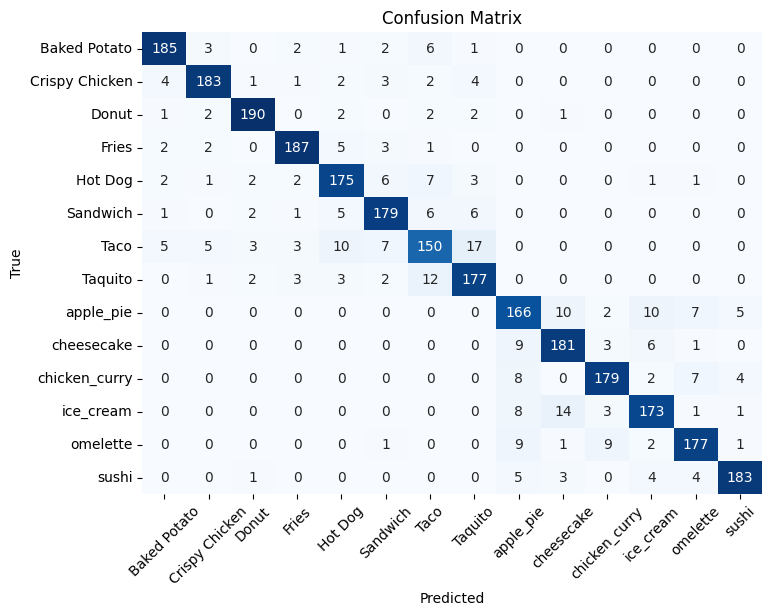

In [ ]:
# Show confusion matrix for fine-tuned model
show_confusion_matrix(ft_y_true, ft_y_pred)

### Sample Predictions
Display example images with predicted vs. true labels.

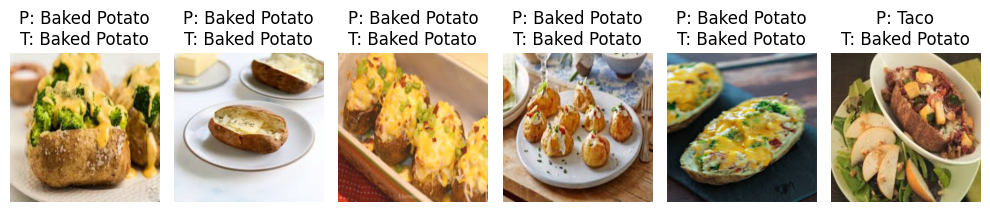

In [ ]:
# Show predictions vs. truth for six test images (for visual assessment)
examples = iter(test_loader)
images, labels = next(examples)
images, labels = images.to(device), labels.to(device)
outputs = fine_tuned_model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(10, 4))
for i in range(min(6, len(images))):
    plt.subplot(1, 6, i+1)
    img = denormalize(images[i].cpu())
    img = img.permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(f"P: {class_names[predicted[i].cpu().item()]}\nT: {class_names[labels[i].cpu().item()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()